In [2]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import csv
import datetime
import gsw
import glob
import matplotlib as mpl
from matplotlib import colors
import matplotlib.cm as cm
#import matplotlib.colormaps as cmaps
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mpl_toolkits.axes_grid1.inset_locator as inset_axes
import numpy.ma as ma
import numpy as np
from numpy import linspace
import os
import pandas as pd
#import rasterio.plot
import scipy.io
from scipy.interpolate import griddata
#import seaborn as sns
import seawater
import seawater.eos80 as sw
import xarray as xr
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from shapely.geometry import LineString, MultiLineString, Point, Polygon
from shapely.ops import unary_union


mpl.style.use('seaborn-muted')
#mpl.rc('font', family ='Arial')

/tmp/ipykernel_553125/576144183.py:39: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-muted')


In [3]:
import glob

headers = []
csv_cast_lat_lon = {}
csv_ctd_data_dict = {}

# directory where the csv files are stored
csv_dir = r"/darnley/CDMeanState/Data/Final/Seal_CTD_and_Argo_type"

# can choose what files to exclude. s04i_97 has an error with oxygen readings below a certain depth, so can remove it this way
# exclude_file = "s04i_97_updated.csv"
exclude_file = "1987_bAU002712_wod_010114182O.nc_153_derivedvariables_ordered_type.csv"


for filename in glob.glob(os.path.join(csv_dir, "*.csv")):
    # can comment this line out if want all the files
    if os.path.basename(filename) != exclude_file:
        # read the csv file
        first = True
        try:
            csv_filehandle = open(filename)
            # print(filename)
            csvfile = csv.reader(csv_filehandle)
        except:
            # print("load fail")
            continue

        # get the file name without the directory path and file extension
        fn = os.path.splitext(os.path.basename(filename))[0]

        # initialize the data structure
        csv_ctd_data_dict[fn] = {}
        
        # Flag variable to check if 'time' column is found
        time_column_found = False
        
        # Flag to check if salinity < 20 is found
        low_salinity_found = False
        
        for row in csvfile:
            if first:
                header = row

                first = False
                for i in range(len(row)):
                    headers.append(row[i])
                    csv_ctd_data_dict[fn][row[i]] = []
                    
                    # Check if 'time' column exists in the header
                    if row[i] == 'time':
                        time_column_found = True

                # If 'time' column is not found, print the error and break
                if not time_column_found:
                    print(f"'time' column not found in file: {filename}")
                    break

            else:
                # Convert salinity to a float and check if it's less than 20
                salinity = float(row[2])  # Assuming salinity is at index 2
                if salinity < 20:
                    low_salinity_found = True
                    print(f"Low salinity found in file: {filename}")
                    break
                
                for i in range(len(row)):
                    csv_ctd_data_dict[fn][headers[i]].append(float(row[i]))

        csv_cast_lat_lon[fn] = {'lat': np.mean(csv_ctd_data_dict[fn]['latitude']), 'lon': np.mean(csv_ctd_data_dict[fn]['longitude'])}

# Print a message if no files with low salinity were found
if not low_salinity_found:
    print("No files with salinity < 20 were found.")

print(csv_cast_lat_lon)


No files with salinity < 20 were found.
{'2016_bAU005882_wod_017871129O.nc_325_derivedvariables_ordered_type': {'lat': -65.702, 'lon': 69.86799999999997}, '2010_bUS025289_wod_015285970O.nc_101_derivedvariables_ordered_type': {'lat': -65.981674, 'lon': 71.21315000000001}, '2017_bIN001232_wod_018153585O.nc_348_derivedvariables_ordered_type': {'lat': -65.965, 'lon': 64.149}, '2022_bAU006636_wod_021308761O.nc_684_derivedvariables_ordered_type': {'lat': -66.76154999999999, 'lon': 64.3392}, 'cnv_subset_PS128_033_01_DOWN_1m_updated_type': {'lat': -64.13699999999999, 'lon': 64.39866667000001}, '2001_bAU003608_wod_011280931O.nc_171_derivedvariables_ordered_type': {'lat': -66.33320000000002, 'lon': 64.0752}, '2022_bAU006485_wod_021968351O.nc_717_derivedvariables_ordered_type': {'lat': -65.51823000000002, 'lon': 67.99732}, '2011_bAU003979_wod_015205537O.nc_38_derivedvariables_ordered_type': {'lat': -65.86199999999997, 'lon': 69.22000000000003}, '2020_bIN001353_wod_020347777O.nc_539_derivedvariabl

In [4]:
#check it loaded all the files 
len(csv_cast_lat_lon)

1148

In [5]:
##run this code to order the dictionary by lat & lon
## i origingally did this when I had less casts and had a legend instead of a colour bar, so not really necessary, 
## but i use this dictionary in code later on so it does'nt hurt to do it or you will have to change the dictionary you call in plots below

csv_lon_ordered = sorted(csv_cast_lat_lon, key=lambda x: (csv_cast_lat_lon[x]['lon']))
csv_lat_ordered = sorted(csv_cast_lat_lon, key=lambda x: (csv_cast_lat_lon[x]['lat']))

In [6]:
# Define the latitude range you want to plot
lat_min = -67
lat_max = -66.5

# Define the longitude range you want to plot
lon_min = 63
lon_max = 73

# Initialize empty lists for each variable
temperature_list = []
cons_temperature_list = []
salinity_list = []
abs_salinity_list = []
oxygen_list = []
latitude_list = []
longitude_list = []
pressure_list = []
depth_list = []
neutral_density_list = []
time_list = []
type_list = []


# Loop over the dictionary and extract the data for each variable
for cast in csv_ctd_data_dict.values():
    temperature_list.append(cast['temperature'])
    cons_temperature_list.append(cast['conservative temperature'])
    salinity_list.append(cast['salinity'])
    abs_salinity_list.append(cast['absolute salinity'])
    try:
        oxygen_list.append(cast['oxygen'])
    except KeyError:
        pass
    #oxygen_list.append(cast['oxygen'])
    latitude_list.append(cast['latitude'])
    longitude_list.append(cast['longitude'])
    pressure_list.append(cast['pressure'])
    depth_list.append(cast['depth'])
    neutral_density_list.append(cast['neutral density'])
    time_list.append(cast['time'])
    type_list.append(cast['type'])



# Convert the lists to NumPy arrays
temperature = np.concatenate(temperature_list)
cons_temperature = np.concatenate(cons_temperature_list)
salinity = np.concatenate(salinity_list)
abs_salinity = np.concatenate(abs_salinity_list)
oxygen = np.concatenate(oxygen_list)
latitude = np.concatenate(latitude_list)
longitude = np.concatenate(longitude_list)
pressure = np.concatenate(pressure_list)
depth = np.concatenate(depth_list)
neutral_density = np.concatenate(neutral_density_list)
time = np.concatenate(time_list)
type = np.concatenate(type_list)

In [7]:
#split data up into argo, seal & ship so can make them different markers in plots

seals_data = type == 1
ships_data = type == 2
argo_data = type == 3

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]
ships_oxygen = oxygen[ships_data]

argo_latitude = latitude[argo_data]
argo_longitude = longitude[argo_data]
argo_cons_temperature = cons_temperature[argo_data]
argo_abs_salinity = abs_salinity[argo_data]
argo_depth = depth[argo_data]
argo_neutral_density = neutral_density[argo_data]
argo_time = time[argo_data]
argo_oxygen = oxygen[argo_data]

In [8]:
#load colour maps
cmap_temp = cmocean.cm.thermal
cmap_salt = cmocean.cm.haline
cmap_dens = cmocean.cm.dense
cmap_deep = cmocean.cm.deep
cmap_ice = cmocean.cm.ice

# #old way of getting these that got updated
#cmap_temp = plt.cm.get_cmap('cmo.thermal')
# cmap_salt = plt.cm.get_cmap('cmo.haline')
# cmap_dens = plt.cm.get_cmap('cmo.dense')
# cmap_deep = plt.cm.get_cmap('cmo.deep')


In [9]:
#load bathymetry data

# Open the NetCDF file with xarray
gebco_full = xr.open_dataset('../Data/Final/bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')


<Figure size 640x480 with 0 Axes>

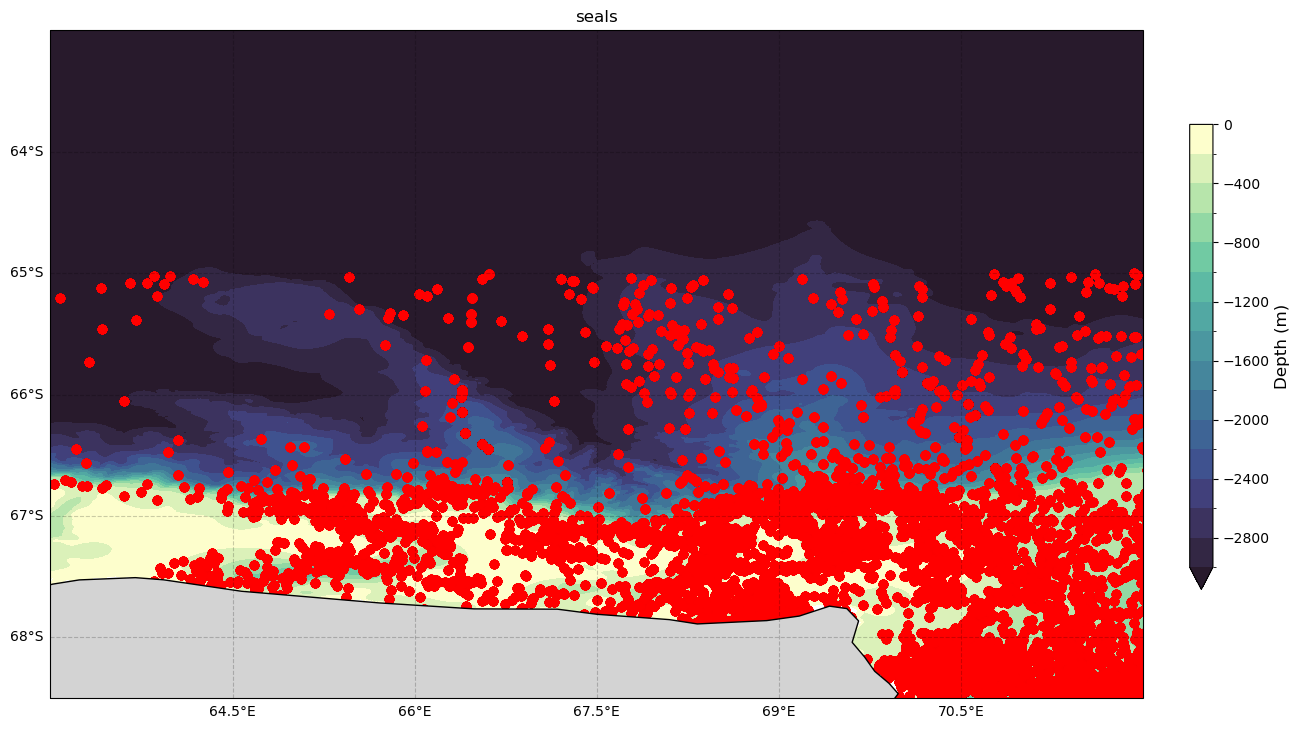

In [10]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot the contour polygon
ax.scatter(seals_longitude, seals_latitude, color='red')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.title('seals')

plt.show()

<Figure size 640x480 with 0 Axes>

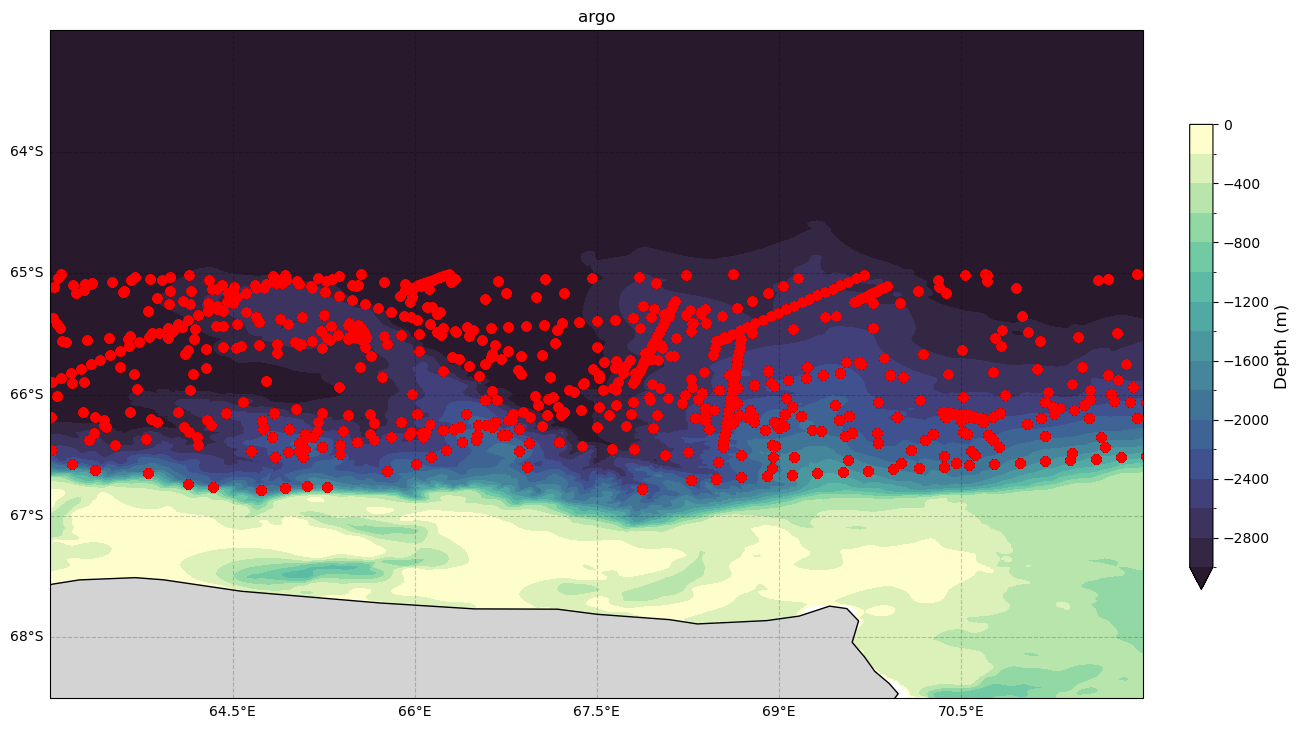

In [11]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot the contour polygon
ax.scatter(argo_longitude, argo_latitude, color='red')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.title('argo')

plt.show()

<Figure size 640x480 with 0 Axes>

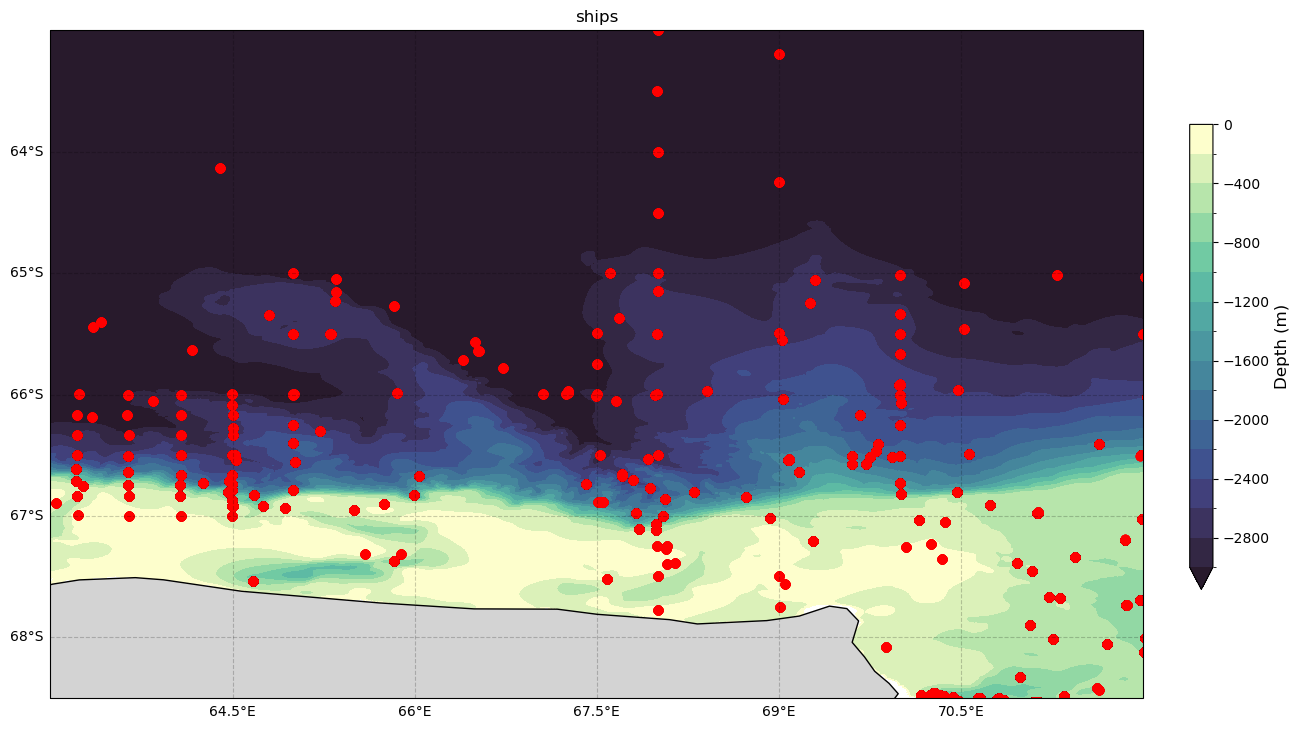

In [12]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot the contour polygon
ax.scatter(ships_longitude, ships_latitude, color='red')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.title('ships')

plt.show()

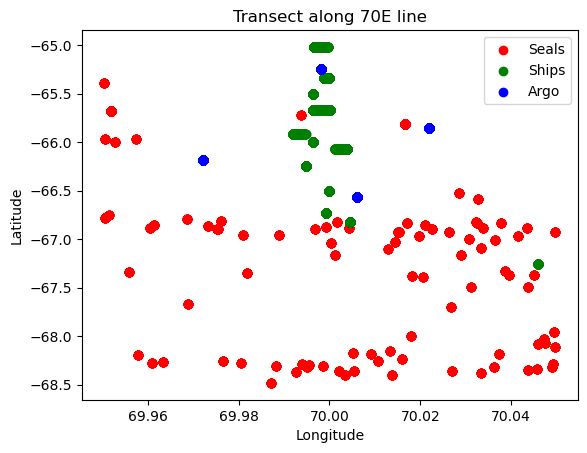

In [39]:
import matplotlib.pyplot as plt

# Define the range for the transect along 70E line
min_longitude = 69.95
max_longitude = 70.05

# Create a boolean mask for points within the specified range
in_range_seals = (seals_longitude >= min_longitude) & (seals_longitude <= max_longitude)
in_range_ships = (ships_longitude >= min_longitude) & (ships_longitude <= max_longitude)
in_range_argo = (argo_longitude >= min_longitude) & (argo_longitude <= max_longitude)

# Plot seals data in red
plt.scatter(seals_longitude[in_range_seals], seals_latitude[in_range_seals], color='red', label='Seals')

# Plot ships data in green
plt.scatter(ships_longitude[in_range_ships], ships_latitude[in_range_ships], color='green', label='Ships')

# Plot argo data in blue
plt.scatter(argo_longitude[in_range_argo], argo_latitude[in_range_argo], color='blue', label='Argo')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Transect along 70E line')
plt.legend()

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

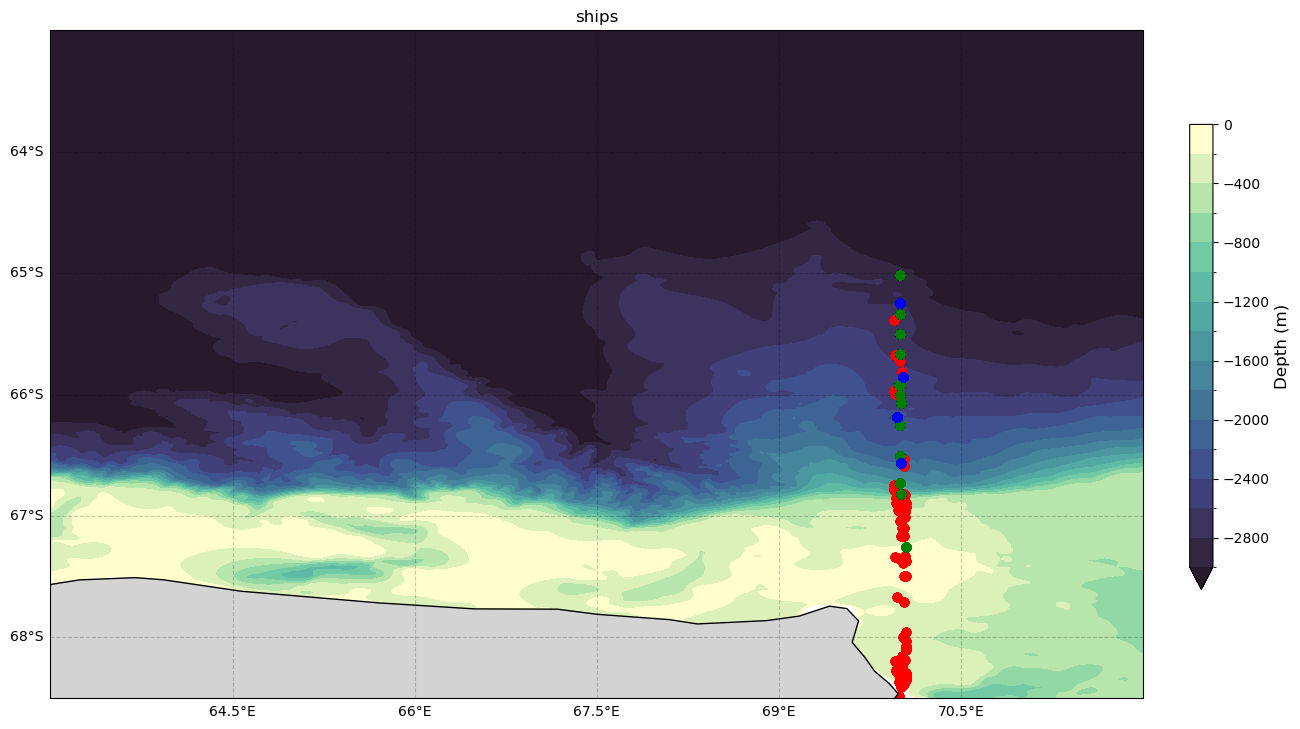

In [40]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot seals data in red
plt.scatter(seals_longitude[in_range_seals], seals_latitude[in_range_seals], color='red', label='Seals')

# Plot ships data in green
plt.scatter(ships_longitude[in_range_ships], ships_latitude[in_range_ships], color='green', label='Ships')

# Plot argo data in blue
plt.scatter(argo_longitude[in_range_argo], argo_latitude[in_range_argo], color='blue', label='Argo')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.title('ships')

plt.show()

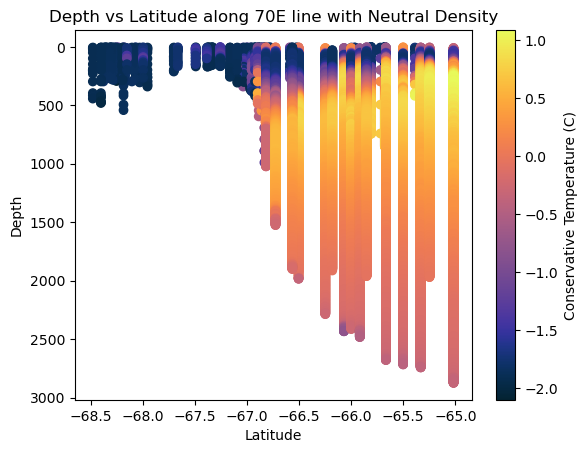

In [41]:
# Extract relevant variables for each data type
seals_data = {
    'latitude': seals_latitude[in_range_seals],
    'longitude': seals_longitude[in_range_seals],
    'depth': seals_depth[in_range_seals],
    'cons_temperature': seals_cons_temperature[in_range_seals],
    'abs_salinity': seals_abs_salinity[in_range_seals],
    'neutral_density': seals_neutral_density[in_range_seals]
}

ships_data = {
    'latitude': ships_latitude[in_range_ships],
    'longitude': ships_longitude[in_range_ships],
    'depth': ships_depth[in_range_ships],
    'cons_temperature': ships_cons_temperature[in_range_ships],
    'abs_salinity': ships_abs_salinity[in_range_ships],
    'neutral_density': ships_neutral_density[in_range_ships]
}

argo_data = {
    'latitude': argo_latitude[in_range_argo],
    'longitude': argo_longitude[in_range_argo],
    'depth': argo_depth[in_range_argo],
    'cons_temperature': argo_cons_temperature[in_range_argo],
    'abs_salinity': argo_abs_salinity[in_range_argo],
    'neutral_density': argo_neutral_density[in_range_argo]
}

# Combine the data into a single dataset
combined_data = {
    'latitude': np.concatenate([seals_data['latitude'], ships_data['latitude'], argo_data['latitude']]),
    'depth': np.concatenate([seals_data['depth'], ships_data['depth'], argo_data['depth']]),
    'cons_temperature': np.concatenate([seals_data['cons_temperature'], ships_data['cons_temperature'], argo_data['cons_temperature']]),
    'abs_salinity': np.concatenate([seals_data['abs_salinity'], ships_data['abs_salinity'], argo_data['abs_salinity']]),
    'neutral_density': np.concatenate([seals_data['neutral_density'], ships_data['neutral_density'], argo_data['neutral_density']])
}

# Plot depth vs latitude along the 70E line
plt.scatter(combined_data['latitude'], combined_data['depth'], c=combined_data['cons_temperature'], cmap='cmo.thermal')
# Reverse the y-axis to have 0m at the top
plt.gca().invert_yaxis()
plt.colorbar(label='Conservative Temperature (C)')
plt.xlabel('Latitude')
plt.ylabel('Depth')
plt.title('Depth vs Latitude along 70E line with Neutral Density')
plt.show()


In [42]:
# Open the NetCDF file with xarray
gebco_full = xr.open_dataset('../Data/Final/bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')


# Extract the bathymetry data for the longitude line of 68°E
# longitude_line = 65
# longitude_line = 68
longitude_line = 70 

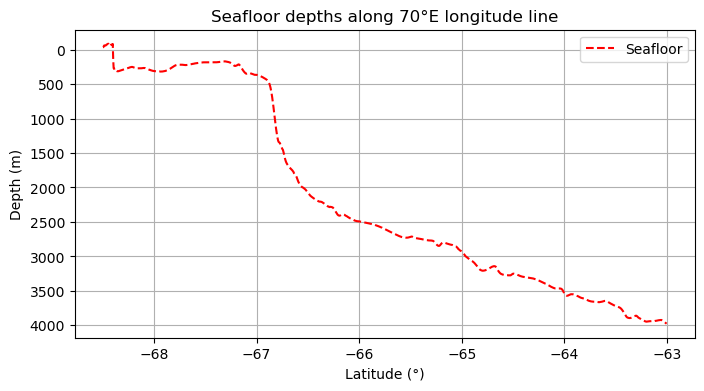

In [43]:
bathymetry_along_transect = gebco_full.sel(lon=longitude_line, method='nearest')


# Extract latitude and depth values
latitude_values = bathymetry_along_transect['lat'].values
depth_values = -bathymetry_along_transect['elevation'].values  # Negative values because bathymetry is negative


# Now, you have the latitude and seafloor depth values along the 68°E longitude line.

# Plot the seafloor depths along the 68°E longitude line
plt.figure(figsize=(8, 4))
plt.plot(latitude_values, depth_values, color='red', linestyle='--', label='Seafloor')
plt.xlabel('Latitude (°)')
plt.ylabel('Depth (m)')
plt.title(f'Seafloor depths along {longitude_line}°E longitude line')
plt.legend()
plt.grid()
# Invert the y-axis
plt.gca().invert_yaxis()
plt.show()

In [46]:
#I got memory issues coz the data is too big, so try changing from float64 to float32
# Convert the arrays to float32
latitude = latitude.astype(np.float32)
depth = depth.astype(np.float32)

In [47]:
# Prepare the grid of X, Z values for interpolation
n = 10  # Example downsampling factor
X, Z = np.meshgrid(latitude[::n], depth[::n])


# Define the grid points for interpolation
grid_lon = np.linspace(latitude.min(), latitude.max(), 50)
grid_depth = np.linspace(depth.min(), depth.max(), 50)
grid_X, grid_Z = np.meshgrid(grid_lon, grid_depth)


# Perform the interpolation using griddata
grid_cons_temp = griddata((latitude, depth), cons_temperature, (grid_X, grid_Z), method='linear')
grid_neu_dens = griddata((latitude, depth), neutral_density, (grid_X, grid_Z), method='linear')
grid_abs_salt = griddata((latitude, depth), abs_salinity, (grid_X, grid_Z), method='linear')

: 